> For OCR (optical character recognition), I am using pytesseract library
>
> for Image processing, I am using OpenCV.

> I am experimenting with various ways to extract the required information from image like Bounding box, segmenting image, working on pixel level and working on string formats.
>
> The code is bit messy and little hard to understand.

# <span style= 'color:blue'>Imports </span>

In [51]:
import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
import cv2 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from pytesseract import Output
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
bl_ = Fore.BLACK

# plt.rcParams['figure.figsize'] = (20,12)

In [2]:
PATH_IMG = 'H:\\Interviews\\Masters india assignment\\mlassignmentmastersindia\\'

In [3]:
os.listdir(PATH_IMG)

['1291908241.jpg',
 '19019155.jpg',
 'Decathlon Invoice.jpg',
 'Decathlon Tax Invoice.jpg',
 'IGST NO.333.jpg',
 'IGST NO.334.jpg',
 'Invoice  - 10001.jpg',
 'Invoice - 20004.jpg',
 'Sales_Invoice_1EOU192001343.jpg',
 'Sales_Invoice_1EOU192001344.jpg']

In [4]:
image_paths = [os.path.join(PATH_IMG, x) for x in os.listdir(PATH_IMG)]

In [5]:
bad_image_path = image_paths[2]
good_image_path = image_paths[0]

In [6]:
good_image_path

'H:\\Interviews\\Masters india assignment\\mlassignmentmastersindia\\1291908241.jpg'

# <span style = 'color: blue'> OpenCV </span>

## 2.0 Functions

In [7]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def plot_image(image, figsize = (25,15), gray = True):
    plt.figure(figsize=figsize)
    if gray:
        plt.imshow(image, label = 'Original', cmap = 'gray')
    else:
        plt.imshow(image, label = 'Original')
    plt.title('Original')

def display(image):
    dpi = 80
    # image = plt.imread(im_path)

    height, width  = image.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(image, cmap='gray')

    plt.show()


def invert_image(image):
    image = cv2.bitwise_not(image)
    return image


def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def binarization(image, thresh_val = 180, 
            maxval = 240, threshold_type = cv2.THRESH_TOZERO):
    thresh, image_bw = cv2.threshold(
        image, thresh_val, maxval, threshold_type
    )
    return thresh, image_bw


def noise_removal(image, row_shape = 1, col_shape = 1):
    kernel = np.ones((row_shape, col_shape), np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    kernel_1 = np.ones((row_shape, col_shape), np.uint8)
    image = cv2.erode(image, kernel_1, iterations= 1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_1)
    image = cv2.medianBlur(image, 3)
    return image


def thin_font(image, row_shape = 1, col_shape = 1):
    image = invert_image(image)
    kernel = np.ones((row_shape, col_shape), np.uint8)
    image = cv2.erode(image, kernel, iterations = 1)
    image = invert_image(image)
    return image


def thick_font(image, row_shape = 1, col_shape = 1):
    image = invert_image(image)
    kernel = np.ones((row_shape, col_shape), np.uint8)
    image = cv2.erode(image, kernel, iterations = 1)
    image = invert_image(image)
    return image


def image_sharpening(image, i = 9):
    kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,i,-1], 
                              [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel_sharpening)
    return sharpened


def bounding_box(image):
    blur = cv2.GaussianBlur(image, (9,9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,13))
    dilate = cv2.dilate(thresh, kernel, iterations= 1)
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key = lambda x: cv2.boundingRect(x)[0])
    return cnts

## Bad image Image processing and OCR

### Using only gray scale and Binarization

In [ ]:
bad_image = read_img(bad_image_path)
plot_image(bad_image, figsize= (25,15))

In [ ]:
bad_image_gray = grayscale(bad_image)
plt.figure(figsize = (25,15))
plt.imshow(bad_image_gray, cmap='gray')

In [ ]:
print(f'For Unprocessed image {y_}',pytesseract.image_to_string(bad_image))

In [ ]:
print(f'For grayscale image {y_}',pytesseract.image_to_string(bad_image_gray))

In [ ]:
bad_image_thick = thick_font(bad_image_gray, row_shape= 1, col_shape= 1)
_ , bad_image_thick = binarization(bad_image_thick, thresh_val= 180, maxval= 240)
bad_image_thick = image_sharpening(bad_image_thick, i = 9)
plot_image(bad_image_thick)

In [ ]:
thresh_bad , bad_image_bin = binarization(bad_image_gray, thresh_val= 155, maxval= 220)
plt.figure(figsize = (25,15))
plt.imshow(bad_image_bin, cmap='gray')

In [ ]:
print(f'For binarized image {y_}',pytesseract.image_to_string(bad_image_bin))

## Good image processing

In [ ]:
good_image = read_img(good_image_path)
plot_image(good_image)

In [ ]:
print(pytesseract.image_to_string(good_image))

In [ ]:
good_image_gray = grayscale(good_image)
_, good_image_bin = binarization(good_image_gray)
plot_image(good_image_bin)

### Bounding box

In [ ]:
blur = cv2.GaussianBlur(good_image_bin, (9,9), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,13))
dilate = cv2.dilate(thresh, kernel, iterations= 1)
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key = lambda x: cv2.boundingRect(x)[0])

In [ ]:
X,Y , W, H=cv2.boundingRect(cnts[0])
X,Y,W,H

In [ ]:
plot_image(good_image_bin)

In [ ]:
plot_image(good_image_bin[Y+10:Y+H-10, X+10:X+W-10])

In [ ]:
_, good_image_bin = binarization(good_image_gray)
plot_image(good_image_bin)

In [ ]:
img_exp=good_image_bin.copy()

In [ ]:
exp = img_exp[Y+10:Y+H-10, X+10:X+W-10]

In [ ]:
blur = cv2.GaussianBlur(exp, (5,11), 0)

In [ ]:
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,13))
dilate = cv2.dilate(thresh, kernel, iterations= 1)

In [ ]:
plot_image(dilate)

In [ ]:
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# cnts = sorted(cnts, key = lambda x: cv2.boundingRect(x)[0])

In [ ]:
rect = []
for c in cnts:
    size_rect = cv2.boundingRect(c)
    rect.append(list(size_rect))

In [ ]:
rect = np.array(rect)
rect.shape

In [ ]:
T = rect[rect[:,0].argsort()]

In [ ]:
T=T[T[:,1].argsort(kind = 'mergesort')]

In [ ]:
T

### Clustering exp

In [ ]:
clustering_data = T[:,0:2]

In [ ]:
plt.scatter(x = clustering_data[:,0], y=clustering_data[:,1])

In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(clustering_data)

In [ ]:
aggo_clustering = AgglomerativeClustering()
aggo_clustering = aggo_clustering.fit(data)

In [ ]:
aggo_clustering.fit_predict(data)

In [ ]:
dbscan = DBSCAN(eps = 0.06, min_samples= 2).fit(data)
dbscan.labels_

In [ ]:
sns.scatterplot(x = clustering_data[:,0], y=clustering_data[:,1], hue = dbscan.labels_)

In [ ]:
clustering_data

### Continue

In [ ]:
first_4 = T[:4]

In [ ]:
first_4  # x , y, w, h

In [ ]:
first_4

In [ ]:
2208-(2122+53)

In [ ]:
new = []
for i,arr in enumerate(first_4):
    x, y, w, h = arr
    try:
        x_1, y_1, w_1, h_1 = first_4[i+1]
        if x_1 - (x + w) < 50 and y == y_1:
            x_new, y_new, w_new, h_new = x, y, (x_1-x+w_1), max(h, h_1)
            new.append([x_new, y_new, w_new, h_new])
    except:
        pass

In [ ]:
new = np.array(new)

In [ ]:
for c in new:
    print(c)
    x, y, w, h = c
    cv2.rectangle(exp, (x, y), (x+w, y+h), (36,255,12), 2)

In [ ]:
for c in cnts:
    print(c)
    x, y, w, h = cv2.boundingRect(c)
    if h>20 and w >20:
        cv2.rectangle(exp, (x, y), (x+w, y+h), (36,255,12), 2)
    

In [ ]:
plot_image(exp)

## 2.2 Binarization image

In [ ]:
img =read_img(bad_image_path)

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (40,20))
plt.imshow(gray_img, cmap= 'gray')

In [ ]:
thresh, img_bw = cv2.threshold(gray_img, 180, 240,cv2.THRESH_TOZERO)

In [ ]:
plt.figure(figsize = (40,20))
plt.imshow(img_bw, cmap= 'Greys_r')

In [ ]:

img_bw2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 15,10
)

In [ ]:
plt.figure(figsize = (40,20))
plt.imshow(img_bw2, cmap= 'Greys_r')

## 2.1 Image sharpening

In [ ]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,9,-1], 
                              [-1,-1,-1]])
sharpened = cv2.filter2D(img, -1, kernel_sharpening)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sharpened)
plt.title('Sharpened')
plt.subplot(1,2,2)
plt.imshow(img)

## Image Erosion

In [ ]:
kernel = np.ones((4,2), np.uint8)
erosion = cv2.erode(img, kernel, iterations = 1)
plt.subplot(1,2,1)
plt.imshow(erosion)
plt.subplot(1,2,2)
plt.imshow(img)

In [ ]:
kernel = np.ones((4,2), np.uint8)
erosion = cv2.erode(img, kernel, iterations = 1)

kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,9,-1], 
                              [-1,-1,-1]])
sharpened = cv2.filter2D(erosion, -1, kernel_sharpening)

plt.subplot(1,2,1)
plt.imshow(sharpened)
plt.subplot(1,2,2)
plt.imshow(img)

## Clearing other images

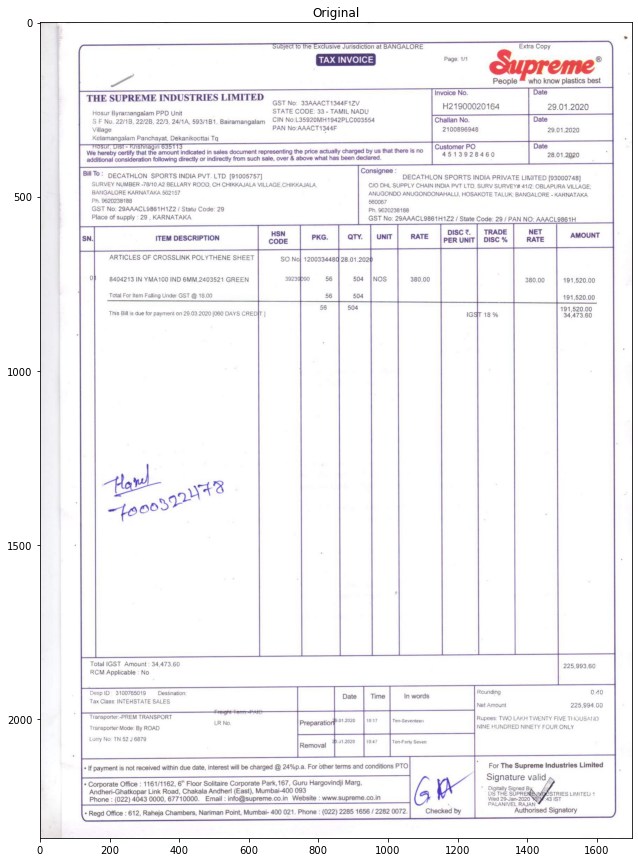

In [193]:
img = read_img(image_paths[6])
plot_image(img)

In [201]:
img_gray = grayscale(img)
img_bin = binarization(img_gray)[1]

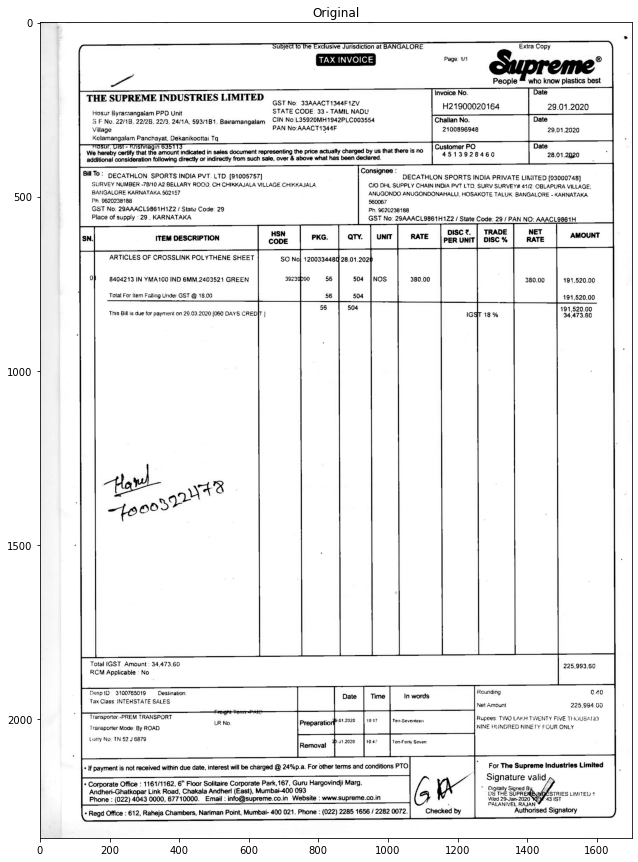

In [203]:
plot_image(img_bin)

In [202]:
pytesseract.image_to_string(img_bin)

'a\n\nubect to the Exctusive Jurisdiction at BANGALORE\n\nTAX INVOICE\n\nExtra Copy\nPage: 1/1 ®\n\nPeople ™ who know plastics best\n\nTHE SUPREME INDUSTRIES LIMITED\n\nHosur Byraraangaiam PPD Unit\nSF No. 22/18, 22/2B, 22/3, 24/1A, $93/1B1, Bairamangalam\nVillage\n\nGST No: 33AAACT1344F1ZV\nSTATE CODE. 33- TAMIL NADU\nCIN No.L35920MH1942PLC003554\nPAN No:AAACT1344F\n\nDate\n\n29.01.2020\nDate\n29.01.2020\n\nInvoice No.\n\nH21900020164\n\nChallan No.\n2100896948\n\nKelamangalam Panchayat, Dekanikocttai Tq\n¥ Dist- Krishnagin 3511S 7 :\nWe hereby certify that the amount indicated in sales document representing the price actually charged by us that there is no\nadditional consideration following directly or indirectly from such sale, over & above what has been declared.\n\nCustomer PO\n4513928460\n\nDate\n28.01.2920\n\nDECATHLON SPORTS INDIA PRIVATE LIMITED {93000748}\nC/O DHL SUPPLY CHAIN INDIA PVT LTD, SURV SURVEY# 41/2, OBLAPURA VILLAGE,\nANUGONDO ANUGONDONAHALLI, HOSAKOTE TALUK BANGA

# <span style = 'color:blue'> Tesseract </span>

In [8]:
img = read_img(good_image_path)

In [9]:
# img = read_img(image_paths[6])

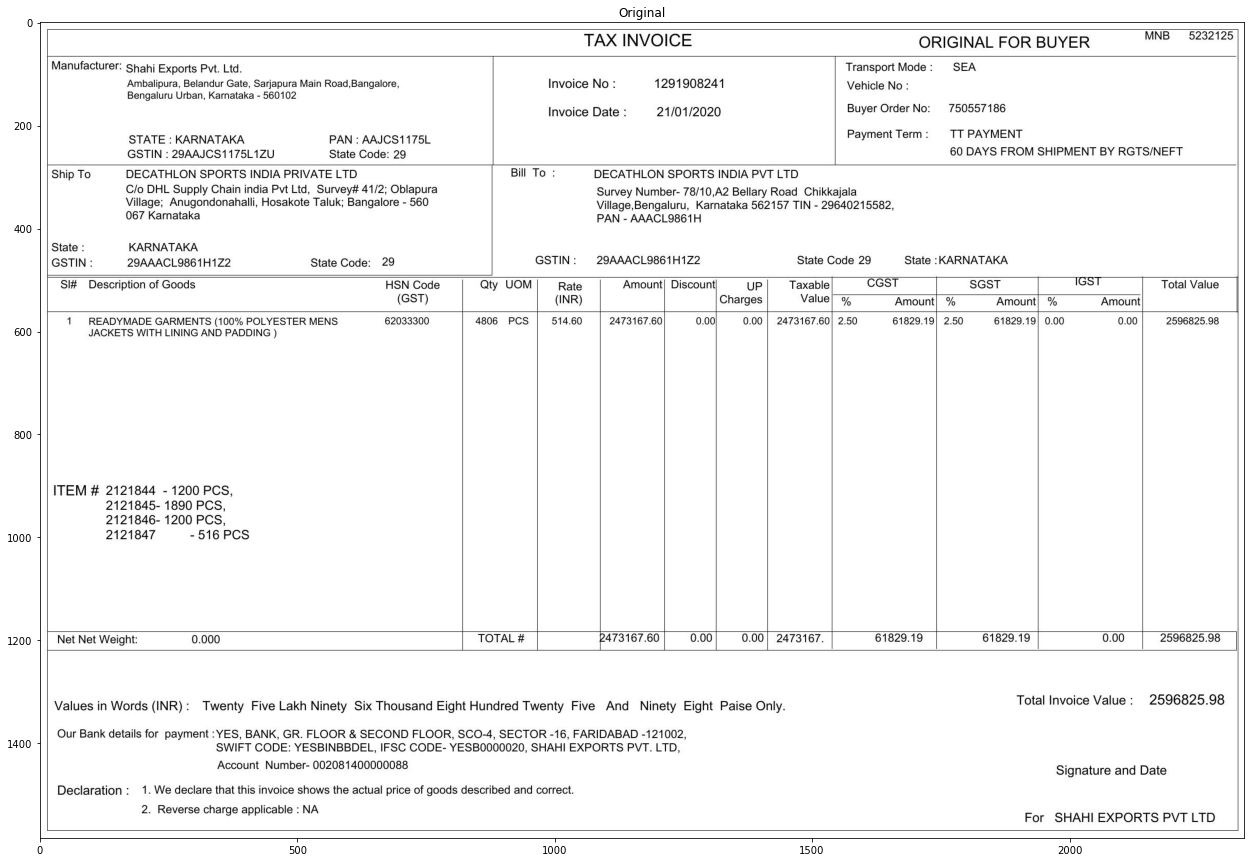

In [10]:
plot_image(img)

In [11]:
image_string = pytesseract.image_to_string(img)
print(image_string)

TAX INVOICE ORIGINAL FOR BUYER WB: “5232125
Manufacturer: Shahi Exports Pvt. Ltd. Transport Mode: SEA
Ambalipura, Belandur Gate, Sarjapura Main Road,Bangalore, Invoice No: 1291908241 Vehicle No :
Bengaluru Urban, Karnataka - 560102
Invoice Date : 21/01/2020 Buyer Order No: 750557186
STATE : KARNATAKA PAN : AAJCS1175L Payment Tem: “TT PAYMENT
GSTIN : 29AAJCS1175L1ZU State Code: 29 60 DAYS FROM SHIPMENT BY RGTS/NEFT
Ship To DECATHLON SPORTS INDIA PRIVATE LTD Bill To : DECATHLON SPORTS INDIA PVT LTD
C/o DHL Supply Chain india Pvt Ltd, Survey# 41/2; Oblapura Survey Number- 78/10,A2 Bellary Road Chikkajala
Village; Anugondonahalli, Hosakote Taluk; Bangalore - 560 Village,Bengaluru, Karnataka 562157 TIN - 29640215582,
067 Karnataka PAN - AAACL9861H
State : KARNATAKA
GSTIN: 29AAACL9861H1Z2 State Code: 29 GSTIN: | 29AAACL9861H1Z2 State Code 29 State :KARNATAKA
Sl# Description of Goods HSN Code Qty UOM Rate Amount] Discount| UP Taxable CGST SGST IGST Total Value
(GST) (INR) Charges Value) % Amo

In [12]:
image_string = image_string.lower()

In [13]:
text = image_string

In [14]:
def pattern_extractor(expression):
    pattern = re.compile(expression)
    matches = pattern.finditer(text)
    print(matches)
    for match in matches:
        print(match)

In [15]:
pattern_extractor(r'(?<=invoice no) {,3}[:] {,3}[0-9a-z/]{1,}')

<re.Match object; span=(170, 182), match=': 1291908241'>


In [16]:
pattern_extractor(r'(?<=invoice date)|(?<=invoice date and time) {,3}[:-] {,3}[0-9a-z/]')

<re.Match object; span=(244, 244), match=''>


In [17]:
pattern_extractor('invoice date {,3}[:-] {,3}[0-9/]*|invoice date and time {,3}[:-] {,3}[0-9/]*')

<re.Match object; span=(232, 257), match='invoice date : 21/01/2020'>


In [18]:
pattern_extractor('(?<=invoice date [(and)&] time)|(?<=invoice date)')

<re.Match object; span=(244, 244), match=''>


In [19]:
image_string.find('invoice no')

160

In [20]:
image_string[160:]

'invoice no: 1291908241 vehicle no :\nbengaluru urban, karnataka - 560102\ninvoice date : 21/01/2020 buyer order no: 750557186\nstate : karnataka pan : aajcs1175l payment tem: “tt payment\ngstin : 29aajcs1175l1zu state code: 29 60 days from shipment by rgts/neft\nship to decathlon sports india private ltd bill to : decathlon sports india pvt ltd\nc/o dhl supply chain india pvt ltd, survey# 41/2; oblapura survey number- 78/10,a2 bellary road chikkajala\nvillage; anugondonahalli, hosakote taluk; bangalore - 560 village,bengaluru, karnataka 562157 tin - 29640215582,\n067 karnataka pan - aaacl9861h\nstate : karnataka\ngstin: 29aaacl9861h1z2 state code: 29 gstin: | 29aaacl9861h1z2 state code 29 state :karnataka\nsl# description of goods hsn code qty uom rate amount] discount| up taxable cgst sgst igst total value\n(gst) (inr) charges value) % amount] % amount] % amount\n1 readymade garments (100% polyester mens 62033300 4806 pcs 514.60 2473167.60 0.00} 0.00 | 2473167.60) 2.50 61829.19| 2.50

In [21]:
print(pytesseract.image_to_alto_xml(img))

b'<?xml version="1.0" encoding="UTF-8"?>\n<alto xmlns="http://www.loc.gov/standards/alto/ns-v3#" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.loc.gov/standards/alto/ns-v3# http://www.loc.gov/alto/v3/alto-3-0.xsd">\n\t<Description>\n\t\t<MeasurementUnit>pixel</MeasurementUnit>\n\t\t<sourceImageInformation>\n\t\t\t<fileName>C:\\Users\\HP\\AppData\\Local\\Temp\\tess_or04a5gb.PNG</fileName>\n\t\t</sourceImageInformation>\n\t\t<OCRProcessing ID="OCR_0">\n\t\t\t<ocrProcessingStep>\n\t\t\t\t<processingSoftware>\n\t\t\t\t\t<softwareName>tesseract v5.0.1.20220118</softwareName>\n\t\t\t\t</processingSoftware>\n\t\t\t</ocrProcessingStep>\n\t\t</OCRProcessing>\n\t</Description>\n\t<Layout>\n\t\t<Page WIDTH="2339" HEIGHT="1584" PHYSICAL_IMG_NR="0" ID="page_0">\n\t\t\t<PrintSpace HPOS="0" VPOS="0" WIDTH="2339" HEIGHT="1584">\n\t\t\t\t<GraphicalElement ID="cblock_0" HPOS="14" VPOS="1" WIDTH="2312" HEIGHT="27"></Graphic

## Final Experiment

In [22]:
data=pytesseract.image_to_data(img, output_type=Output.DICT)

In [23]:
data.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [24]:
data['text']

['',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 'TAX',
 'INVOICE',
 'ORIGINAL',
 'FOR',
 'BUYER',
 'WB:',
 '“5232125',
 '',
 'Manufacturer:',
 'Shahi',
 'Exports',
 'Pvt.',
 'Ltd.',
 'Transport',
 'Mode:',
 'SEA',
 '',
 'Ambalipura,',
 'Belandur',
 'Gate,',
 'Sarjapura',
 'Main',
 'Road,Bangalore,',
 'Invoice',
 'No:',
 '1291908241',
 'Vehicle',
 'No',
 ':',
 '',
 'Bengaluru',
 'Urban,',
 'Karnataka',
 '-',
 '560102',
 '',
 'Invoice',
 'Date',
 ':',
 '21/01/2020',
 'Buyer',
 'Order',
 'No:',
 '750557186',
 '',
 'STATE',
 ':',
 'KARNATAKA'

In [25]:
data_df = pd.DataFrame(data)
data_df.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,2339,1584,-1,
1,2,1,1,0,0,0,14,1,2312,27,-1,
2,3,1,1,1,0,0,14,1,2312,27,-1,
3,4,1,1,1,1,0,14,1,2312,27,-1,
4,5,1,1,1,1,1,14,1,2312,27,95.000000,


In [26]:
clean_df = data_df[~((data_df['text'] == '') | (data_df['text'] == ' ') | (data_df['text'] == ':'))]

In [27]:
clean_df.reset_index(inplace= True)

In [28]:
clean_df.drop('index', inplace= True, axis = 1)

C:\Users\HP\AppData\Local\Temp/ipykernel_18332/1619329374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.drop('index', inplace= True, axis = 1)


In [29]:
clean_df['text'] = clean_df['text'].map(lambda x: x.lower())

C:\Users\HP\AppData\Local\Temp/ipykernel_18332/2487650934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['text'] = clean_df['text'].map(lambda x: x.lower())


In [30]:
clean_df.iloc[21]

level                5
page_num             1
block_num           24
par_num              1
line_num             3
word_num             7
left               988
top                110
width               76
height              18
conf         95.964699
text           invoice
Name: 21, dtype: object

In [109]:
clean_df.head(10)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
0,5,1,24,1,1,1,1056,23,64,24,95.966629,tax,NaN,NaN,1120,47
1,5,1,24,1,1,2,1133,23,132,24,95.966629,invoice,0.0,13.0,1265,47
2,5,1,24,1,1,3,1707,28,143,22,96.330345,original,3.0,442.0,1850,50
3,5,1,24,1,1,4,1862,28,62,22,96.913445,for,0.0,12.0,1924,50
4,5,1,24,1,1,5,1935,28,103,22,96.324173,buyer,0.0,11.0,2038,50
5,5,1,24,1,1,6,2146,18,46,16,49.060524,wb:,-16.0,108.0,2192,34
6,5,1,24,1,1,7,2231,18,85,16,51.077900,“5232125,0.0,39.0,2316,34
7,5,1,24,1,2,1,24,76,133,16,96.482010,manufacturer:,58.0,-2292.0,157,92
8,5,1,24,1,2,2,168,82,54,16,83.943871,shahi,6.0,11.0,222,98
9,5,1,24,1,2,3,231,82,73,20,96.868019,exports,4.0,9.0,304,102


In [129]:
clean_df['top']-(clean_df['top'].shift(1)+clean_df['height'].shift(1))

0       NaN
1     -24.0
2     -19.0
3     -22.0
4     -22.0
       ... 
282    74.0
283   -18.0
284   -18.0
285   -18.0
286   -18.0
Length: 287, dtype: float64

In [110]:
clean_df['vertical_gap']=clean_df['top']- (clean_df['top'].shift(1)+clean_df['height'].shift(1))

C:\Users\HP\AppData\Local\Temp/ipykernel_18332/1654045841.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
clean_df['horizontal_gap'] = clean_df['left'] - (clean_df['left'].shift(1)+clean_df['width'].shift(1))

C:\Users\HP\AppData\Local\Temp/ipykernel_18332/953780189.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [112]:
clean_df['X_2'] = clean_df['left']+clean_df['width']
clean_df['Y_2'] = clean_df['top']+clean_df['height']

C:\Users\HP\AppData\Local\Temp/ipykernel_18332/2206179724.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Temp/ipykernel_18332/2206179724.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
clean_df.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
0,5,1,24,1,1,1,1056,23,64,24,95.966629,tax,NaN,NaN,1120,47
1,5,1,24,1,1,2,1133,23,132,24,95.966629,invoice,-24.0,13.0,1265,47
2,5,1,24,1,1,3,1707,28,143,22,96.330345,original,-19.0,442.0,1850,50
3,5,1,24,1,1,4,1862,28,62,22,96.913445,for,-22.0,12.0,1924,50
4,5,1,24,1,1,5,1935,28,103,22,96.324173,buyer,-22.0,11.0,2038,50


<AxesSubplot:ylabel='horizontal_gap'>

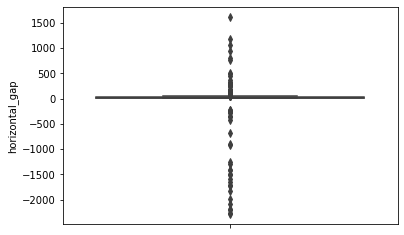

In [114]:
sns.boxplot(data = clean_df, y = 'horizontal_gap')

In [115]:
px.histogram(data_frame=clean_df, x = 'horizontal_gap', nbins = 750, range_x= (-100,300))

In [116]:
clean_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
level,287.0,5.000000,0.000000,5.0,5.00,5.0,5.0,5.0
page_num,287.0,1.000000,0.000000,1.0,1.00,1.0,1.0,1.0
block_num,287.0,24.801394,1.661661,24.0,24.00,24.0,25.0,31.0
par_num,287.0,1.000000,0.000000,1.0,1.00,1.0,1.0,1.0
line_num,287.0,9.041812,7.036244,1.0,2.00,8.0,15.0,23.0
word_num,287.0,6.749129,4.672467,1.0,3.00,6.0,10.0,22.0
left,287.0,897.634146,643.895744,23.0,318.00,726.0,1424.5,2236.0
top,287.0,720.829268,503.199076,18.0,316.00,534.0,1318.0,1535.0
width,287.0,66.540070,36.733747,4.0,41.50,58.0,86.0,200.0
height,287.0,17.275261,3.698069,2.0,16.00,16.0,18.0,33.0


In [117]:
def conditions(X,Y,W,H):
    # right side
    top_condition = (clean_df['top'] >= (Y-5))
    left_condition = (clean_df['left'] >= (X+W))
    right_condition = (clean_df['left'] <= (X+W+80))
    bottom_condition = (clean_df['top'] <= (Y+(H/2)))

    row_condition = (top_condition & bottom_condition & right_condition & left_condition)

    # on bottom side
    top_condition_bt = (clean_df['top'] >= (Y+H))
    left_condition_bt = (clean_df['left'] >= (X-H))
    right_condition_bt = (clean_df['left'] <= (X+W+20))
    bottom_condition_bt = (clean_df['top'] <= (Y+(2*H)))

    column_condition = (top_condition_bt & bottom_condition_bt & right_condition_bt & left_condition_bt)
    return row_condition, column_condition

In [118]:
variable = ['no', 'number']
invoice = clean_df[clean_df.text == 'invoice'].index
final_idx = []
for index in invoice:
    X, Y, W, H=clean_df.iloc[index][['left', 'top', 'width', 'height']].to_list()
    row_condition, column_condition = conditions(X,Y,W,H)

    # clean_df[((980 <= clean_df['left']) & (clean_df['left'] <= (X+W+20))) & (clean_df['width'] >=76) & (clean_df['top'] >= Y)]
    no_df = clean_df[(row_condition | column_condition)]

    # if no_df.shape[0] == 1 and (clean_df.text[no_df.index].values in ['no:', 'no', 'number']):
    #     print(index, no_df.index)
    for obs in no_df.index:
        re_exp = variable[0]+' {,3}[:-]*|'+variable[1]+' {,2}[:-]*'
        if re.match(re_exp,clean_df.text[obs]):
        # if clean_df.text[obs] in ['date:', 'date']:
            print(clean_df.text[obs])
            no_idx = obs
            final_idx = [index, obs]
            break
    # if final_idx is not None:
    #     break
    print('u')

new_df = clean_df.iloc[final_idx]
X, Y, W, H =new_df.left.min(), new_df.top.min(), new_df.X_2.max()-new_df.left.min(), new_df.Y_2.max()-new_df.top.min()
right_condition, bottom_condition = conditions(X,Y,W,H)
no_df = clean_df[right_condition | bottom_condition]

target = no_df.text


    

    # if clean_df.text[index] == 'invoice' and clean_df.text[index+1] in ['no:', 'no :']:
    #     print(index)

u
no:
u
u
u
u


In [41]:
final_idx

[21, 22]

In [42]:
target

23    1291908241
Name: text, dtype: object

In [119]:
strt = 'description of goods'

In [120]:
strt.split()

['description', 'of', 'goods']

In [178]:
index_1 = clean_df[clean_df['text'] == 'description'].index[0]
clean_df.iloc[index_1:]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
121,5,1,24,1,14,2,96,501,108,20,93.964226,description,-16.0,25.0,204,521
122,5,1,24,1,14,3,212,501,19,16,97.006271,of,-20.0,8.0,231,517
123,5,1,24,1,14,4,237,501,64,16,96.996475,goods,-16.0,6.0,301,517
124,5,1,24,1,14,5,672,502,44,16,96.945442,hsn,-15.0,371.0,716,518
125,5,1,24,1,14,6,725,502,51,16,96.637184,code,-16.0,9.0,776,518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,5,1,31,1,1,1,1913,1535,36,18,92.714554,for,74.0,-273.0,1949,1553
283,5,1,31,1,1,2,1971,1535,73,18,85.970802,shahi,-18.0,22.0,2044,1553
284,5,1,31,1,1,3,2055,1535,116,18,96.175728,exports,-18.0,11.0,2171,1553
285,5,1,31,1,1,4,2181,1535,46,18,95.738831,pvt,-18.0,10.0,2227,1553


In [179]:
previous_idx = index_1-1
next_idx = clean_df[(clean_df['horizontal_gap'] > 15) & (clean_df.index > index_1)].index[0]

In [180]:
X, Y, X2, Y2 = (clean_df['left'][previous_idx]+clean_df['width'][previous_idx]+10), clean_df['top'][index_1], clean_df['left'][next_idx]-10, clean_df['Y_2'][index_1]
X,Y,X2,Y2

(81, 501, 662, 521)

In [181]:
# max vertical gap

bottom_description = clean_df[(clean_df.index > index_1) & (clean_df['X_2']<= X2) & (clean_df['Y_2'] > Y2)]

In [182]:
T=bottom_description['vertical_gap'].argmax()
T=bottom_description.index[T]
Y2_2 = bottom_description['top'][T]-10

In [183]:
X,Y,W,H = X, Y2, X2-X, Y2_2-Y2 
X,Y,W,H

(81, 521, 581, 368)

In [184]:
exp = img.copy()

In [185]:
bound_image = cv2.rectangle(exp, (X, Y), (X2, Y2_2), (36,255,12), 2)

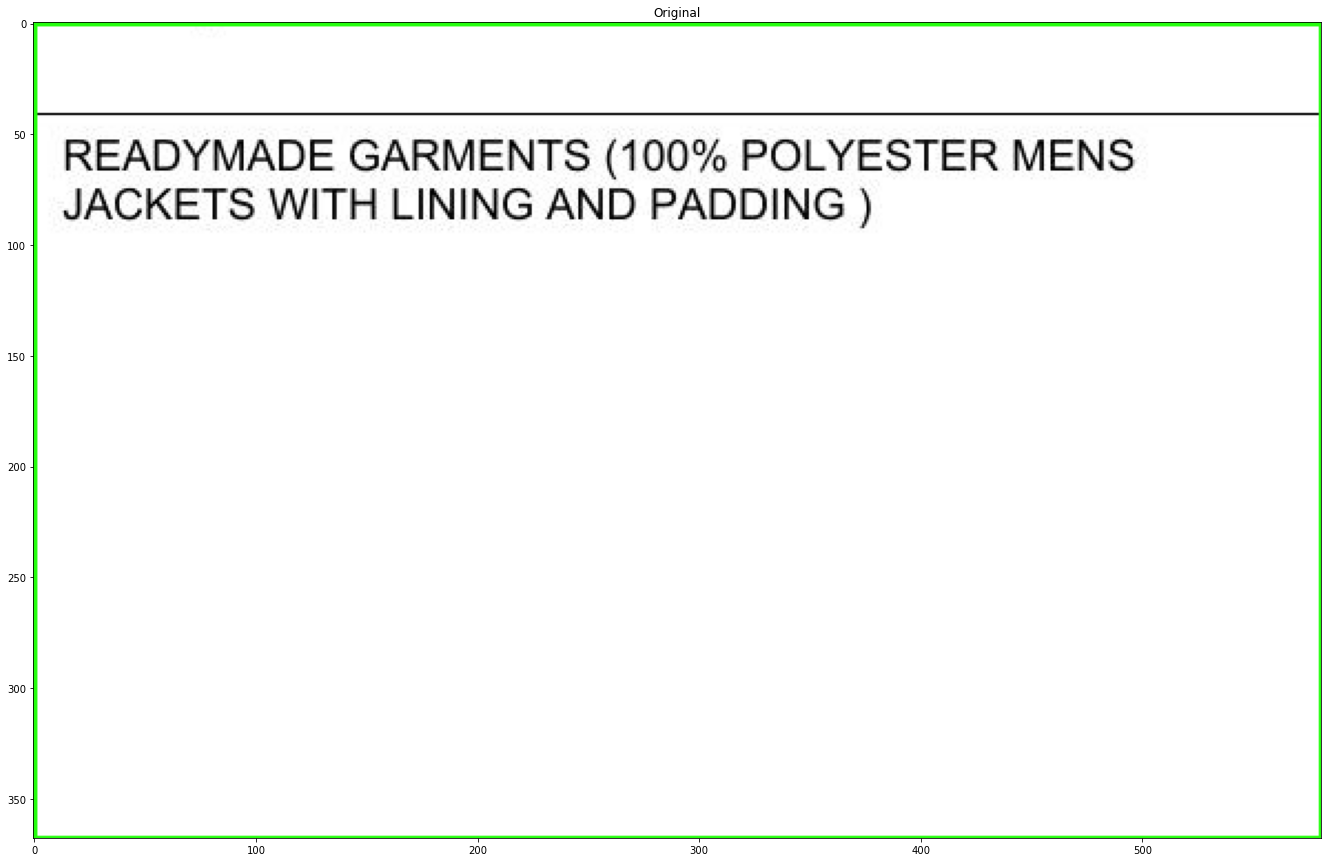

In [189]:
plot_image(exp[Y:Y2_2,X:X2])

In [190]:
pytesseract.image_to_string(exp[Y:Y2_2,X:X2])

'READYMADE GARMENTS (100% POLYESTER MENS\nJACKETS WITH LINING AND PADDING )\n\n'

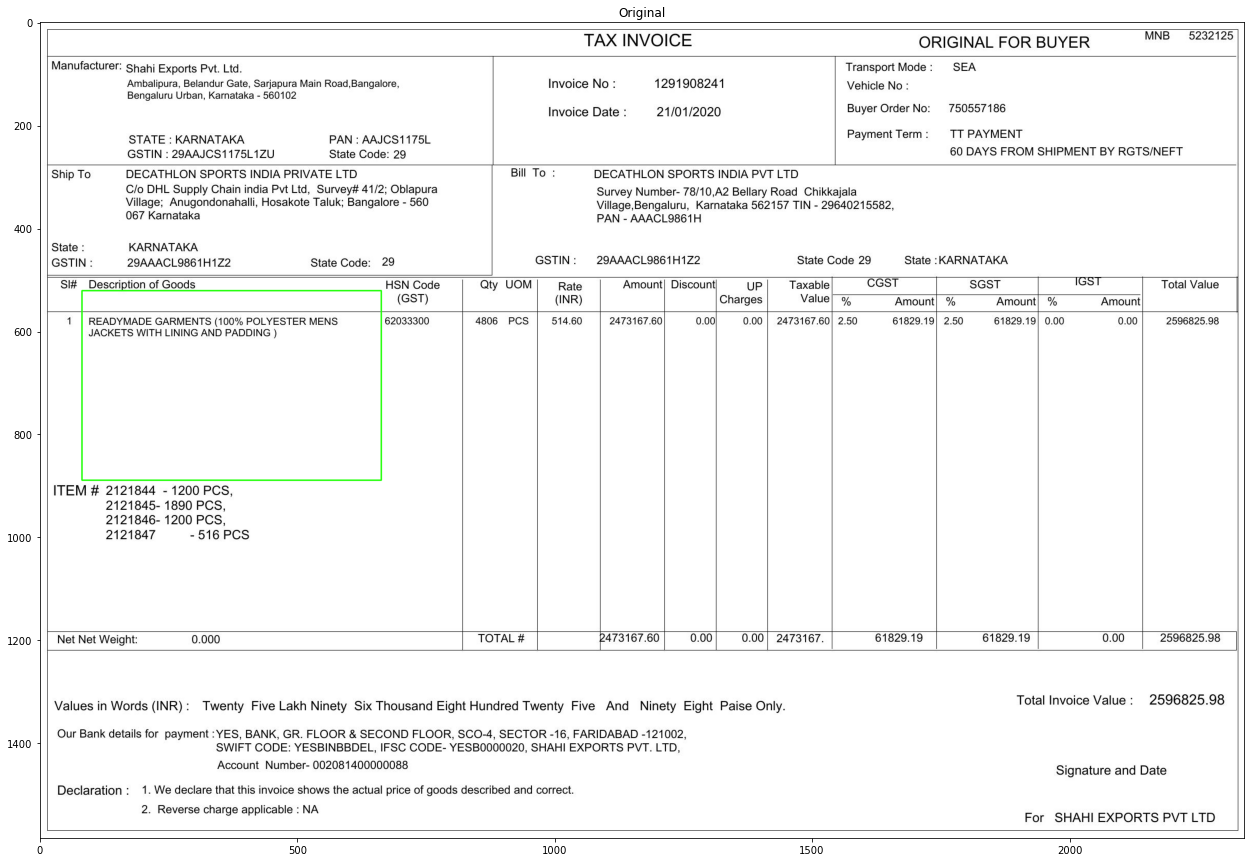

In [177]:
plot_image(exp)

## Rough works

In [43]:
clean_df.iloc[final_idx]['height'].value_counts().index.shape[0] == 1

True

In [44]:
new_df = clean_df.iloc[final_idx]
new_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
21,5,1,24,1,3,7,988,110,76,18,95.964699,invoice,-2.0,292.0,1064,128
22,5,1,24,1,3,8,1074,110,42,18,92.052216,no:,0.0,10.0,1116,128


In [45]:
X, Y, W, H =new_df.left.min(), new_df.top.min(), new_df.X_2.max()-new_df.left.min(), new_df.Y_2.max()-new_df.top.min()

In [46]:
top_condition = (clean_df['top'] >= (Y-5))
left_condition = (clean_df['left'] >= (X+W))
right_condition = (clean_df['left'] <= (X+W+20))
bottom_condition = (clean_df['top'] <= (Y+(H/2)))

row_condition = (top_condition & bottom_condition & right_condition & left_condition)

# on bottom side
top_condition_bt = (clean_df['top'] >= (Y+H))
left_condition_bt = (clean_df['left'] >= (X-H))
right_condition_bt = (clean_df['left'] <= (X+W+20))
bottom_condition_bt = (clean_df['top'] <= (Y+(2*H)))

In [47]:
X,Y,W,H

(988, 110, 128, 18)

In [101]:
right_condition, bottom_condition = conditions(X,Y,W,H)

In [102]:
clean_df[right_condition|bottom_condition]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
33,5,1,24,1,5,4,1198,165,123,18,96.443863,21/01/2020,0.0,74.0,1321,183


In [103]:
clean_df[row_condition]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2


In [104]:
no_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
33,5,1,24,1,5,4,1198,165,123,18,96.443863,21/01/2020,0.0,74.0,1321,183


In [105]:
clean_df.iloc[final_idx].min()

level                     5
page_num                  1
block_num                24
par_num                   1
line_num                  5
word_num                  1
left                    988
top                     165
width                    50
height                   18
conf              93.210594
text                   date
vertical_gap            0.0
horizontal_gap         10.0
X_2                    1064
Y_2                     183
dtype: object

In [106]:
X, Y, W, H=clean_df.iloc[21][['left', 'top', 'width', 'height']].to_list()
X,Y,W,H

(988, 110, 76, 18)

In [107]:
multi=clean_df[((980 <= clean_df['left'])) & (clean_df['width'] >=76) & (clean_df['top'] >= Y)]

In [108]:
multi

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,vertical_gap,horizontal_gap,X_2,Y_2
21,5,1,24,1,3,7,988,110,76,18,95.964699,invoice,-2.0,292.0,1064,128
23,5,1,24,1,3,9,1194,110,132,18,96.744980,1291908241,0.0,78.0,1326,128
31,5,1,24,1,5,1,988,165,76,18,96.947563,invoice,34.0,491.0,1064,183
33,5,1,24,1,5,4,1198,165,123,18,96.443863,21/01/2020,0.0,74.0,1321,183
37,5,1,24,1,5,8,1765,159,109,16,44.741089,750557186,0.0,38.0,1874,175
42,5,1,24,1,6,7,1568,209,86,21,0.000000,payment,-6.0,810.0,1654,230
45,5,1,24,1,6,10,1802,209,105,16,83.120430,payment,0.0,9.0,1907,225
54,5,1,24,1,7,10,1937,243,113,16,96.257294,shipment,0.0,9.0,2050,259
56,5,1,24,1,7,12,2094,243,124,16,91.849030,rgts/neft,0.0,8.0,2218,259
66,5,1,24,1,8,11,1077,287,133,16,96.442863,decathlon,3.0,96.0,1210,303


In [112]:
txt = 'invoice'
re_str = re.escape(txt) + ' {,3}[:-]*'
re.match(re_str, 'invoice :')

<re.Match object; span=(0, 9), match='invoice :'>

In [110]:
for i in multi.index:
    if clean_df.text[i] in ['invoice']:
        print('yes', i)

yes 21
yes 31
yes 210


In [ ]:
# on left side
top_condition = (clean_df['top'] >= (Y-5))
left_condition = (clean_df['left'] >= (X+W))
right_condition = (clean_df['left'] <= (X+W+20))
bottom_condition = (clean_df['top'] <= (Y+(H/2)))

row_condition = (top_condition & bottom_condition & right_condition & left_condition)

# on bottom side
top_condition_bt = (clean_df['top'] >= (Y+H))
left_condition_bt = (clean_df['left'] >= (X-H))
right_condition_bt = (clean_df['left'] <= (X+W+20))
bottom_condition_bt = (clean_df['top'] <= (Y+(2*H)))

column_condition = (top_condition_bt & bottom_condition_bt & right_condition_bt & left_condition_bt)

# clean_df[((980 <= clean_df['left']) & (clean_df['left'] <= (X+W+20))) & (clean_df['width'] >=76) & (clean_df['top'] >= Y)]
no_df = clean_df[(row_condition | column_condition)]

In [ ]:
re.match('no {,3}[:-]*|number {,2}[:-]*',)

In [ ]:
if no_df.shape[0] == 1 and (clean_df.text[no_df.index].values in ['no:', 'no', 'number']):
    print('yrd')

In [ ]:
no_df.shape

In [ ]:
invoice_df = clean_df.iloc[21:21+3]
invoice_df

In [ ]:
clean_df.to_csv('df.csv')